In [1]:
import os
import torch
import torchvision
import mlflow
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn as NN
import torch.optim as optim

from PIL import Image

In [2]:
# Detecting if a GPU is available:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used: {torch.cuda.get_device_name(0)}") if device == "cuda" else print("No GPU available: Using CPU")

Device used: NVIDIA GeForce RTX 5080


### Defining the GAN architecture

In [3]:
class Generator(NN.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = NN.Sequential(
            NN.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            NN.BatchNorm2d(ngf * 8),
            NN.ReLU(True),
            NN.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            NN.BatchNorm2d(ngf * 4),
            NN.ReLU(True),
            NN.ConvTranspose2d(ngf * 4, ngf *2, 4, 2, 1, bias=False),
            NN.BatchNorm2d(ngf * 2),
            NN.ReLU(True),
            NN.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            NN.BatchNorm2d(ngf),
            NN.ReLU(True),
            NN.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            NN.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(NN.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = NN.Sequential(
            NN.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            NN.LeakyReLU(0.2, inplace=True),
            NN.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            NN.BatchNorm2d(ndf * 2),
            NN.LeakyReLU(0.2, inplace=True),
            NN.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            NN.BatchNorm2d(ndf * 4),
            NN.LeakyReLU(0.2, inplace=True),
            NN.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            NN.BatchNorm2d(ndf * 8),
            NN.LeakyReLU(0.2, inplace=True),
            NN.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            NN.Sigmoid() # Comment when using MSELoss
        )

    def forward(self, input):
        return self.main(input)

In [4]:
# Weights init function:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        NN.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        NN.init.normal_(m.weight.data, 1.0, 0.02)
        NN.init.constant_(m.bias.data, 0)

### Define the train function

In [5]:
# Train function for discriminator:
def train_epoch(dataloader, netG, netD, criterion, nz, optimizerG, optimizerD, device, real_label_smooth, noise_std):

    # Metric acumulators:
    running_g_loss = 0.0
    running_d_loss = 0.0
    running_d_x = 0.0
    running_d_g_z1 = 0.0
    running_d_g_z2 = 0.0

    for _, data in enumerate(dataloader, 0):
        ########################## Update the DISCRIMINATOR ##########################
        netD.zero_grad()

        real_images = data[0].to(device)
        b_size = real_images.size(0)

        # --- Add noise to real images ---
        noise_tensor = torch.randn_like(real_images) * noise_std
        real_images_noisy = real_images + noise_tensor
        real_images_noisy = torch.clamp(real_images_noisy, -1.0, 1.0)
        #---------------------------------

        label = torch.full((b_size,), real_label_smooth, dtype=torch.float, device=device)

        output = netD(real_images).view(-1) #No-noisy images
        #output = netD(real_images_noisy).view(-1) # Passing the noisy images to the netD
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake images:
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)

        label.fill_(0.)

        # --- Add noise to fake images ---
        fake_images_detached = fake_images.detach()
        noise_tensor = torch.randn_like(fake_images_detached) * noise_std
        fake_images_noisy = fake_images_detached + noise_tensor
        fake_images_noisy = torch.clamp(fake_images_noisy, -1.0, 1.0)
        # --------------------------------

        output = netD(fake_images.detach()).view(-1) #No-noisy images
        #output = netD(fake_images_noisy).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ########################## Update the GENERATOR ##########################
        netG.zero_grad()

        label.fill_(1.)

        output = netD(fake_images).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()

        running_g_loss += errG.item()
        running_d_loss += errD.item()
        running_d_x += D_x
        running_d_g_z1 += D_G_z1
        running_d_g_z2 += D_G_z2

    n_batches = len(dataloader) # Length of the current batch

    # Getting metric means:
    avg_g_loss = running_g_loss / n_batches
    avg_d_loss = running_d_loss / n_batches
    avg_d_x = running_d_x / n_batches
    avg_d_g_z1 = running_d_g_z1 / n_batches
    avg_d_g_z2 = running_d_g_z2 / n_batches

    return avg_g_loss, avg_d_loss, avg_d_x, avg_d_g_z1, avg_d_g_z2

In [6]:
# Ploting function:
def plot_epoch(epoch, netG, fixed_noise, plots_filename):
    # Generate images:
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()

    # Show images:
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    # Take 64 images to make a grid
    plt.imshow(np.transpose(torchvision.utils.make_grid(fake[:25], padding=2, normalize=True, nrow=5).numpy(), (1,2,0)))
    
    plt.savefig(plots_filename, bbox_inches='tight') 
    plt.show()
    plt.close() # Close to save RAM

In [7]:
# MLFLow information:
EXPERIMENT_NAME = "Defect_Generation_On_Manufactured_Pieces"
RUN_NAME = "Try: Vanilla DCGAN for casting metalic pieces"
SAVE_MODEL_TO_MLFLOW = True #  Save the model onmlruns for MLFlow

if SAVE_MODEL_TO_MLFLOW:
    RUN_NAME = RUN_NAME
else:
    RUN_NAME = f"{RUN_NAME} - NO model saved"

# Hyperparameters:
HP_LR_G = 2e-4 # Learning rate for generator
HP_LR_D = 2e-4 # Learning rate for discriminator
HP_NZ = 100 # Size of noise input vector (latent space)
HP_NC = 3 # Number of channels of the input image (RGB)
HP_NGF = 64 # Number of feature maps in the generator
HP_NDF = 64 # Number of feature maps in the discriminator
HP_N_EPOCHS = 50 # Total training epochs
HP_BATCH_SIZE = 32 # Number of inputs (images) per batch
HP_MODEL_ARCH = "DCGAN" # Model architecture tested
HP_LOSS_FCN = "BCELoss" # Loss Function
HP_OPTIMIZER = "Adam" # Optimizer
HP_REAL_LABEL_SMOOTH = 1. # Target for real images
HP_NOISE_STD = 0.0 # Noise level for discriminator

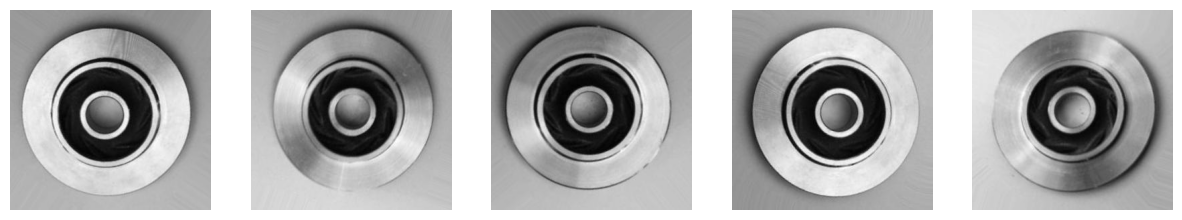

In [8]:
# Define the dataset path
dataset_path = "../data/raw/casting/casting_data/casting_data/train/ok_front"

# Visualize some images
image_files = os.listdir(dataset_path)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = Image.open(os.path.join(dataset_path, image_files[i]))
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

In [9]:
# Transforming the data:
transform = T.Compose([
    T.Resize(64),
    T.CenterCrop(64),
    T.ToTensor(),
    T.Normalize([0.5] * 3, [0.5] * 3)
])

# Create the dataloader from dataset:
dataset = torchvision.datasets.ImageFolder(
    root="../data/raw/casting/casting_data/casting_data/train/", 
    transform=transform
    )
if device == "cuda":
    train_dataloader = torch.utils.data.DataLoader(
        dataset=dataset, 
        batch_size=HP_BATCH_SIZE, 
        shuffle=True,
        num_workers=4, # CPU threads loading the batches
        pin_memory=True, # Transfer form RAM to VRAM
        persistent_workers=True # Same CPU threads in every epoch
        )
    print("Optimizing batches using GPU")
else:
    train_dataloader = torch.utils.data.DataLoader(
        dataset=dataset, 
        batch_size=HP_BATCH_SIZE, 
        shuffle=True,
        )

Optimizing batches using GPU


In [10]:
# Create the generator and discriminator:
netG = Generator(HP_NZ, HP_NGF, HP_NC).to(device)
netD = Discriminator(HP_NC, HP_NDF).to(device)

# Init the weights:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [11]:
# Define the loss function:
if HP_LOSS_FCN == "BCELoss":
    criterion = NN.BCELoss()
elif HP_LOSS_FCN == "MSE_Loss":
    criterion = NN.MSELoss()

# Define the optimizers
optimizerG = optim.Adam(netG.parameters(), lr=HP_LR_G, betas=(0.5, 0.9999))
optimizerD = optim.Adam(netD.parameters(), lr=HP_LR_D, betas=(0.5, 0.9999))

Init training...
Logging parameters to MLFlow
Starting MLFlow Run: Try: Vanilla DCGAN for casting metalic pieces
 Epochs: [0 / 50] Loss_G: 13.4869 Loss_D: 0.5286 D(x): 0.9331 D(G(z)): 0.0862 / 0.0049


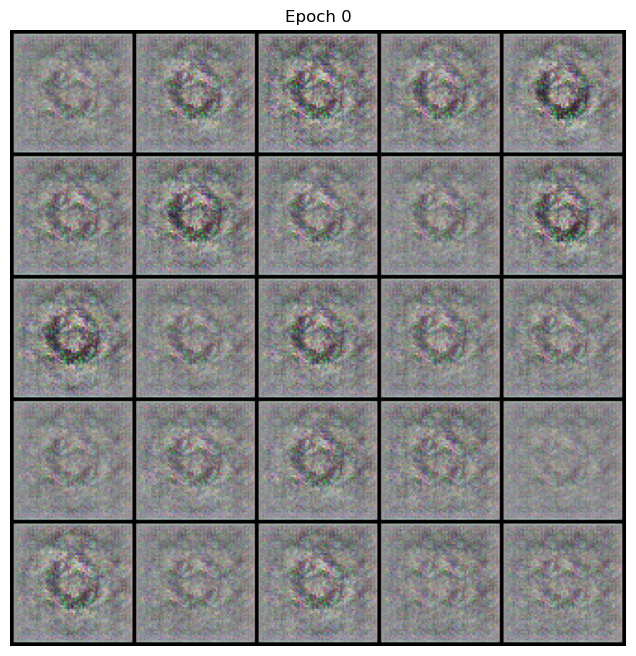

 Epochs: [1 / 50] Loss_G: 8.4267 Loss_D: 0.3897 D(x): 0.9207 D(G(z)): 0.0838 / 0.0161
 Epochs: [2 / 50] Loss_G: 8.0470 Loss_D: 0.2466 D(x): 0.9354 D(G(z)): 0.0600 / 0.0038
 Epochs: [3 / 50] Loss_G: 8.7228 Loss_D: 0.2230 D(x): 0.9383 D(G(z)): 0.0637 / 0.0025
 Epochs: [4 / 50] Loss_G: 8.5368 Loss_D: 0.2025 D(x): 0.9446 D(G(z)): 0.0540 / 0.0044
 Epochs: [5 / 50] Loss_G: 7.4738 Loss_D: 0.0891 D(x): 0.9673 D(G(z)): 0.0309 / 0.0026


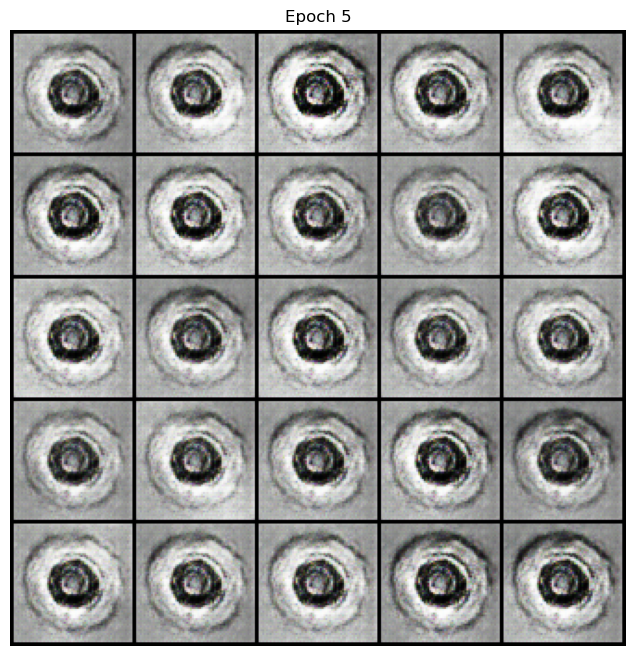

 Epochs: [6 / 50] Loss_G: 8.2569 Loss_D: 0.1384 D(x): 0.9658 D(G(z)): 0.0344 / 0.0035
 Epochs: [7 / 50] Loss_G: 7.2530 Loss_D: 0.1942 D(x): 0.9499 D(G(z)): 0.0489 / 0.0110
 Epochs: [8 / 50] Loss_G: 6.2968 Loss_D: 0.2457 D(x): 0.9344 D(G(z)): 0.0655 / 0.0154
 Epochs: [9 / 50] Loss_G: 6.0037 Loss_D: 0.2092 D(x): 0.9358 D(G(z)): 0.0641 / 0.0206
 Epochs: [10 / 50] Loss_G: 5.6262 Loss_D: 0.2307 D(x): 0.9289 D(G(z)): 0.0714 / 0.0261


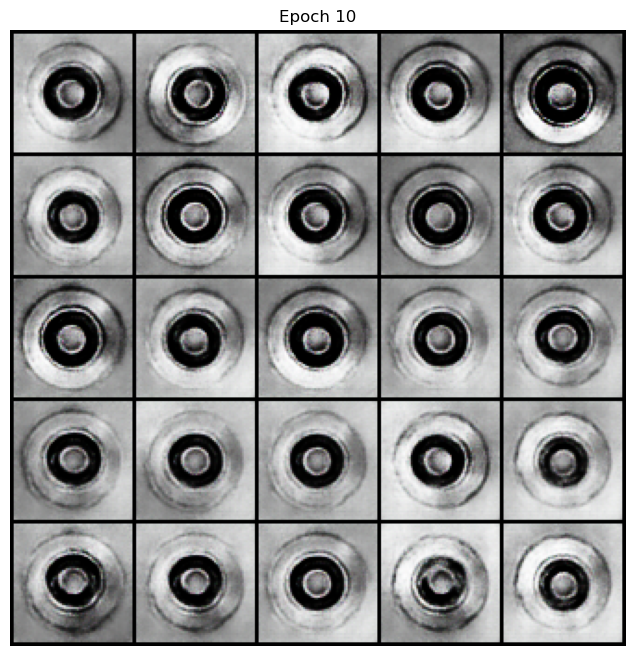

 Epochs: [11 / 50] Loss_G: 5.4010 Loss_D: 0.5003 D(x): 0.8936 D(G(z)): 0.1037 / 0.0462
 Epochs: [12 / 50] Loss_G: 4.0780 Loss_D: 0.3949 D(x): 0.8855 D(G(z)): 0.1146 / 0.0634
 Epochs: [13 / 50] Loss_G: 3.8316 Loss_D: 0.5459 D(x): 0.8426 D(G(z)): 0.1572 / 0.1032
 Epochs: [14 / 50] Loss_G: 3.7479 Loss_D: 0.5536 D(x): 0.8352 D(G(z)): 0.1625 / 0.1022
 Epochs: [15 / 50] Loss_G: 3.4846 Loss_D: 0.5687 D(x): 0.8235 D(G(z)): 0.1763 / 0.1207


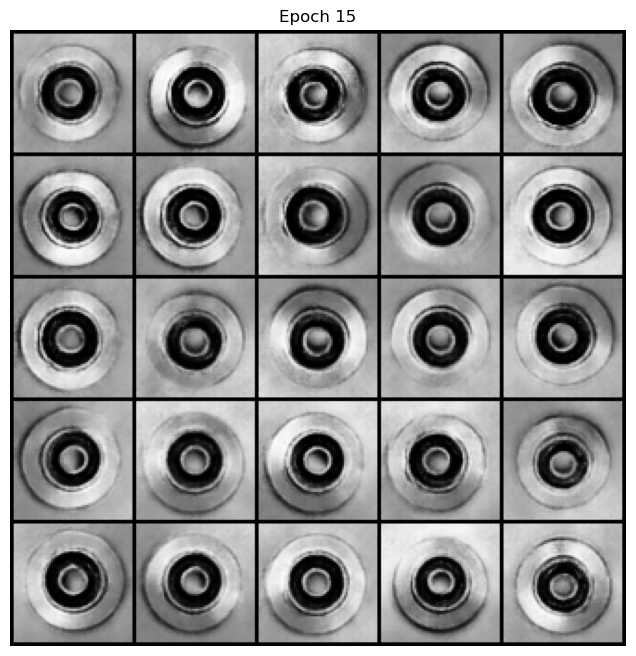

 Epochs: [16 / 50] Loss_G: 3.4059 Loss_D: 0.5810 D(x): 0.8229 D(G(z)): 0.1761 / 0.1196
 Epochs: [17 / 50] Loss_G: 3.4527 Loss_D: 0.5838 D(x): 0.8150 D(G(z)): 0.1851 / 0.1163
 Epochs: [18 / 50] Loss_G: 3.2420 Loss_D: 0.6488 D(x): 0.7970 D(G(z)): 0.2031 / 0.1312
 Epochs: [19 / 50] Loss_G: 3.3727 Loss_D: 0.4868 D(x): 0.8375 D(G(z)): 0.1608 / 0.1016
 Epochs: [20 / 50] Loss_G: 3.1474 Loss_D: 0.6085 D(x): 0.8093 D(G(z)): 0.1922 / 0.1179


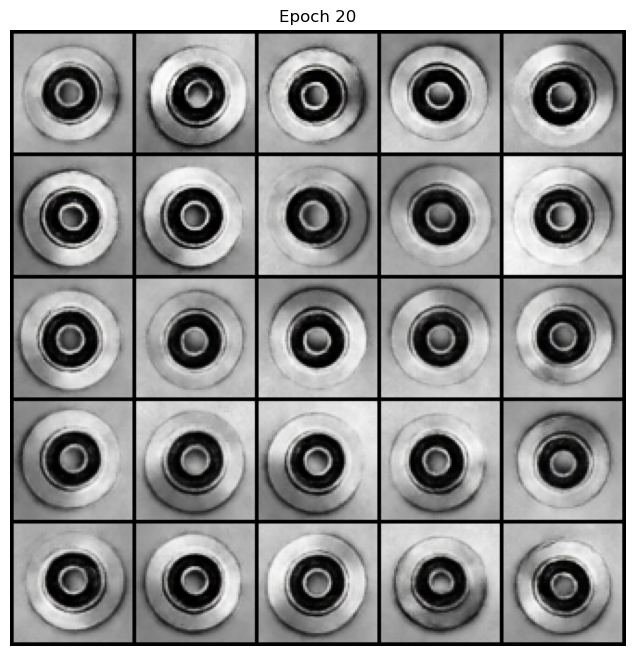

 Epochs: [21 / 50] Loss_G: 3.2463 Loss_D: 0.5398 D(x): 0.8186 D(G(z)): 0.1802 / 0.1152
 Epochs: [22 / 50] Loss_G: 3.3193 Loss_D: 0.5063 D(x): 0.8312 D(G(z)): 0.1696 / 0.1039
 Epochs: [23 / 50] Loss_G: 3.2876 Loss_D: 0.5433 D(x): 0.8188 D(G(z)): 0.1803 / 0.1105
 Epochs: [24 / 50] Loss_G: 3.1356 Loss_D: 0.5434 D(x): 0.8146 D(G(z)): 0.1848 / 0.1167
 Epochs: [25 / 50] Loss_G: 3.2773 Loss_D: 0.5358 D(x): 0.8192 D(G(z)): 0.1812 / 0.1099


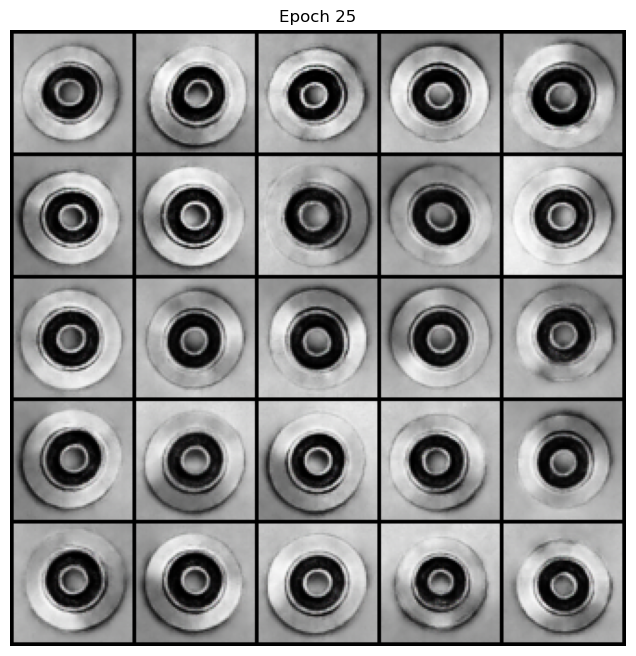

 Epochs: [26 / 50] Loss_G: 3.2287 Loss_D: 0.5644 D(x): 0.8158 D(G(z)): 0.1834 / 0.1136
 Epochs: [27 / 50] Loss_G: 3.2893 Loss_D: 0.4588 D(x): 0.8391 D(G(z)): 0.1575 / 0.0911
 Epochs: [28 / 50] Loss_G: 3.2273 Loss_D: 0.5047 D(x): 0.8263 D(G(z)): 0.1767 / 0.0993
 Epochs: [29 / 50] Loss_G: 3.4094 Loss_D: 0.4088 D(x): 0.8498 D(G(z)): 0.1494 / 0.0855
 Epochs: [30 / 50] Loss_G: 3.3036 Loss_D: 0.6128 D(x): 0.8051 D(G(z)): 0.1947 / 0.1139


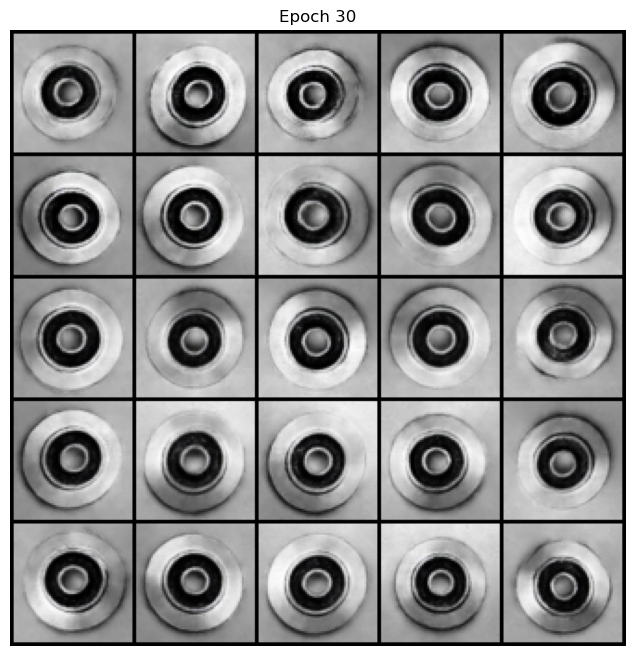

 Epochs: [31 / 50] Loss_G: 3.3629 Loss_D: 0.4468 D(x): 0.8425 D(G(z)): 0.1554 / 0.0884
 Epochs: [32 / 50] Loss_G: 3.4108 Loss_D: 0.4690 D(x): 0.8411 D(G(z)): 0.1589 / 0.0922
 Epochs: [33 / 50] Loss_G: 3.3606 Loss_D: 0.4802 D(x): 0.8317 D(G(z)): 0.1699 / 0.0916
 Epochs: [34 / 50] Loss_G: 3.3628 Loss_D: 0.5204 D(x): 0.8304 D(G(z)): 0.1686 / 0.0946
 Epochs: [35 / 50] Loss_G: 3.3745 Loss_D: 0.4611 D(x): 0.8376 D(G(z)): 0.1621 / 0.0854


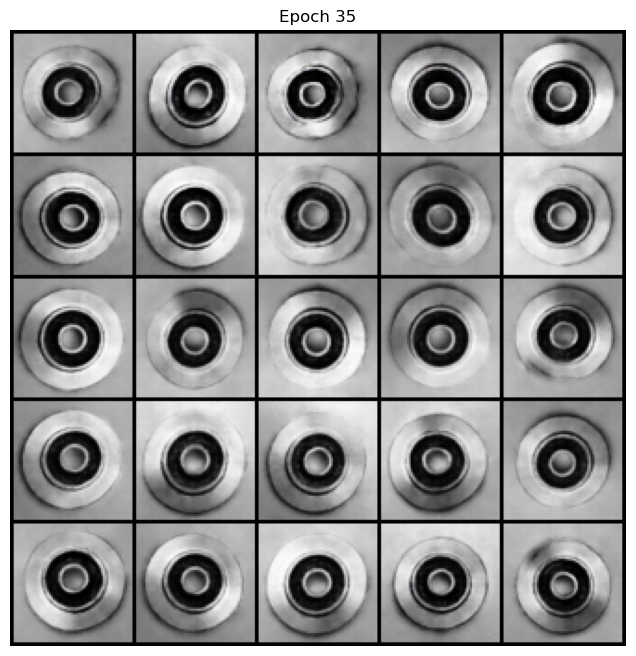

 Epochs: [36 / 50] Loss_G: 3.4242 Loss_D: 0.4799 D(x): 0.8331 D(G(z)): 0.1648 / 0.0923
 Epochs: [37 / 50] Loss_G: 3.3688 Loss_D: 0.5022 D(x): 0.8301 D(G(z)): 0.1710 / 0.0913
 Epochs: [38 / 50] Loss_G: 3.5179 Loss_D: 0.3716 D(x): 0.8609 D(G(z)): 0.1373 / 0.0772
 Epochs: [39 / 50] Loss_G: 3.5200 Loss_D: 0.5227 D(x): 0.8339 D(G(z)): 0.1668 / 0.0937
 Epochs: [40 / 50] Loss_G: 3.3815 Loss_D: 0.5269 D(x): 0.8242 D(G(z)): 0.1759 / 0.0992


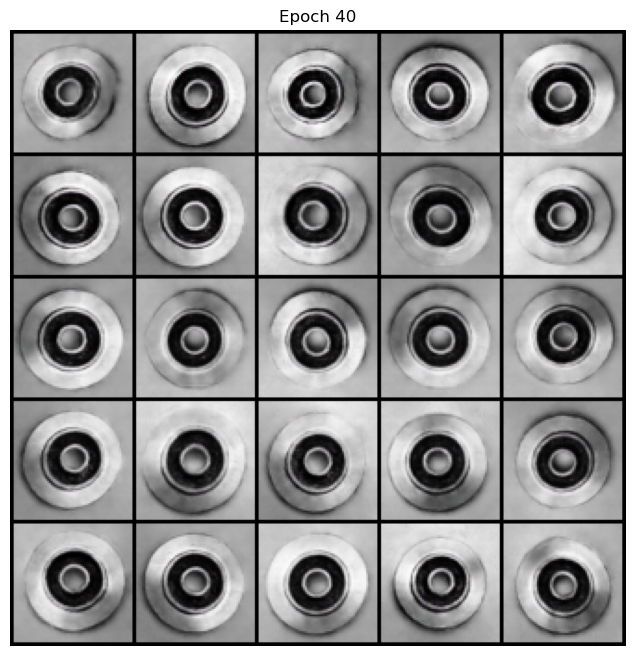

 Epochs: [41 / 50] Loss_G: 3.4138 Loss_D: 0.5070 D(x): 0.8271 D(G(z)): 0.1726 / 0.0925
 Epochs: [42 / 50] Loss_G: 3.3912 Loss_D: 0.4370 D(x): 0.8453 D(G(z)): 0.1546 / 0.0821
 Epochs: [43 / 50] Loss_G: 3.4966 Loss_D: 0.4008 D(x): 0.8562 D(G(z)): 0.1424 / 0.0782
 Epochs: [44 / 50] Loss_G: 3.5791 Loss_D: 0.4033 D(x): 0.8567 D(G(z)): 0.1419 / 0.0739
 Epochs: [45 / 50] Loss_G: 3.5528 Loss_D: 0.4467 D(x): 0.8454 D(G(z)): 0.1549 / 0.0745


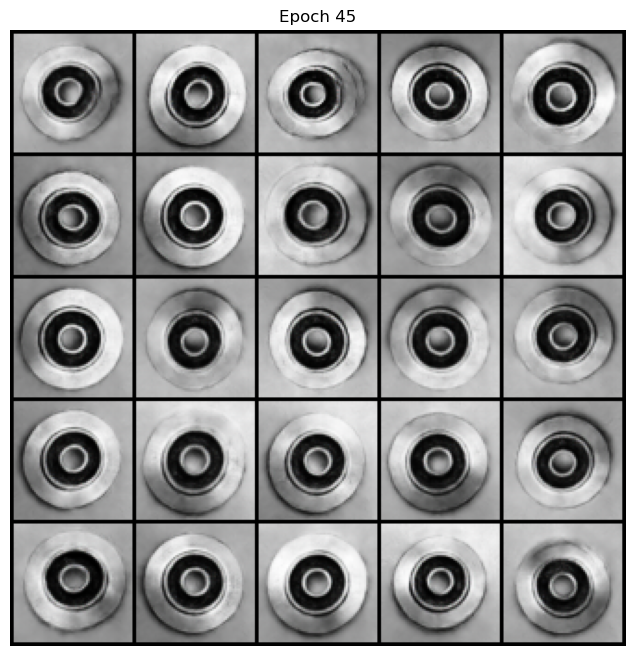

 Epochs: [46 / 50] Loss_G: 3.6723 Loss_D: 0.3698 D(x): 0.8665 D(G(z)): 0.1359 / 0.0703
 Epochs: [47 / 50] Loss_G: 3.6537 Loss_D: 0.4191 D(x): 0.8520 D(G(z)): 0.1467 / 0.0732
 Epochs: [48 / 50] Loss_G: 3.6839 Loss_D: 0.4569 D(x): 0.8479 D(G(z)): 0.1528 / 0.0781


2025/11/29 22:38:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 22:38:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


 Epochs: [49 / 50] Loss_G: 3.6873 Loss_D: 0.2997 D(x): 0.8859 D(G(z)): 0.1140 / 0.0511
Training completed. Saving model...


2025/11/29 22:38:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu129) contains a local version label (+cu129). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/29 22:38:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved; training completed.


In [12]:
# ==========================================================================
# ####### MODEL TRAINING (EXCECUTE ONLY IF RE-TRAINING IS NECESSARY) #######
# ==========================================================================

MLFLOW_TRACKING = True

if MLFLOW_TRACKING:

    mlflow.set_experiment(EXPERIMENT_NAME)

    with mlflow.start_run(run_name=RUN_NAME):
        print("Init training...")
        print("Logging parameters to MLFlow")
        mlflow.log_param('learning_rate_generator', HP_LR_G)
        mlflow.log_param('learning_rate_discriminator', HP_LR_D)
        mlflow.log_param('latent_space_size', HP_NZ)
        mlflow.log_param('channels_input_image', HP_NC)
        mlflow.log_param('n_feature_maps_generator', HP_NGF)
        mlflow.log_param('n_feature_maps_discriminator', HP_NDF)
        mlflow.log_param('n_epochs', HP_N_EPOCHS)
        mlflow.log_param('batch_size', HP_BATCH_SIZE)
        mlflow.log_param('model_architecture', HP_MODEL_ARCH)
        mlflow.log_param('loss_function', HP_LOSS_FCN)
        mlflow.log_param('optimizer', HP_OPTIMIZER)
        mlflow.log_param('real_label_smoth', HP_REAL_LABEL_SMOOTH)
        mlflow.log_param('noise_std', HP_NOISE_STD)

        print(f"Starting MLFlow Run: {mlflow.active_run().info.run_name}")


        # Define fixed noise to produce consistent outputs during training:
        fixed_noise = torch.randn(64, HP_NZ, 1, 1, device=device) # Gausian noise

        # Loss histories:
        loss_g_history = []
        loss_d_history = []

        for epoch in range(HP_N_EPOCHS):
            avg_g_loss, avg_d_loss, avg_d_x, avg_d_g_z1, avg_d_g_z2 = train_epoch(
                dataloader=train_dataloader,
                netG=netG,
                netD=netD,
                criterion=criterion,
                nz=HP_NZ,
                optimizerG=optimizerG,
                optimizerD=optimizerD,
                device=device,
                real_label_smooth=HP_REAL_LABEL_SMOOTH,
                noise_std=HP_NOISE_STD
            )

            loss_g_history.append(avg_g_loss)
            loss_d_history.append(avg_d_loss)

            print(  f" Epochs: [{epoch} / {HP_N_EPOCHS}] "
                    f"Loss_G: {avg_g_loss:.4f} "
                    f"Loss_D: {avg_d_loss:.4f} "
                    f"D(x): {avg_d_x:.4f} "
                    f"D(G(z)): {avg_d_g_z1:.4f} / {avg_d_g_z2:.4f}"
                )
            
            mlflow.log_metric('avg_g_loss', avg_g_loss, step=epoch)
            mlflow.log_metric('avg_d_loss', avg_d_loss,step=epoch)
            mlflow.log_metric('avg_d_x', avg_d_x, step=epoch)
            mlflow.log_metric('avg_d_g_z1', avg_d_g_z1, step=epoch)
            mlflow.log_metric('avg_d_g_z2', avg_d_g_z2, step=epoch)
            
            if epoch % 5 == 0:

                # Save figure temporaly:
                plots_save_dir = f"../reports/figures/{HP_MODEL_ARCH}"
                os.makedirs(plots_save_dir, exist_ok=True)

                plots_filename=f"{plots_save_dir}/epoch_{epoch}.png"

                plot_epoch(
                    epoch=epoch,
                    netG=netG,
                    fixed_noise=fixed_noise,
                    plots_filename=plots_filename
                )

                # Save to MLFlow:
                mlflow.log_artifact(plots_filename, 'plots')
                os.remove(plots_filename) # Remove to avoid duplicates.

        # Saving the trained model:
        print("Training completed. Saving model...")
        model_g_save_dir = f"../models/{HP_MODEL_ARCH}_g_casting.pth" # Save dir of generator
        torch.save(netG.state_dict(), model_g_save_dir)
        if SAVE_MODEL_TO_MLFLOW:
            mlflow.log_artifact(model_g_save_dir, 'model_generator')
            mlflow.pytorch.log_model(netG, artifact_path="model_generator")
        print("Model saved; training completed.")
